  ##                      Emotion classification using Deep Learning

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd drive/My Drive/Colab Notebooks/vg/NLP/

/content/drive/My Drive/Colab Notebooks/vg/NLP


In [6]:
!pwd

/content/drive/My Drive/Colab Notebooks/vg/NLP


In [7]:
import pandas as pd
import numpy as np
 
import nltk
from nltk.corpus import stopwords

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from gensim.models import FastText


from contractions import contraction_map
import string,re

from nltk.stem import WordNetLemmatizer


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  import sys


In [8]:
from keras.layers import Dense, Embedding, Bidirectional, SpatialDropout1D,Input, TimeDistributed,Flatten, LSTM,GRU,Dropout
from keras.models import Sequential,save_model,Model
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf

Using TensorFlow backend.


### Data cleaning

In [9]:
data = pd.read_csv('datasets/crowdflower-sentiment-analysis-in-text/text_emotion.csv')

In [10]:
data.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [11]:
data.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [12]:
df_temp = data.copy()

In [13]:
df_temp.dtypes

tweet_id      int64
sentiment    object
author       object
content      object
dtype: object

In [14]:
# Dropping rows with other emotion labels
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'boredom'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'enthusiasm'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'empty'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'fun'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'relief'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'surprise'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'love'].index)
df_temp = df_temp.drop(df_temp[df_temp.sentiment == 'hate'].index)

In [15]:
df_temp.sentiment.value_counts()

neutral      8638
worry        8459
happiness    5209
sadness      5165
anger         110
Name: sentiment, dtype: int64

In [16]:
df_temp

,tweet_id,sentiment,author,content
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ..."
...,...,...,...,...
39992,1753918881,neutral,_Alectrona_,@jasimmo Ooo showing of your French skills!! l...
39993,1753918892,neutral,bushidosan,"@sendsome2me haha, yeah. Twitter has many uses..."
39994,1753918900,happiness,courtside101,Succesfully following Tayla!!
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor


In [17]:
df_temp = df_temp.drop('author',axis=1)
df_temp

,tweet_id,sentiment,content
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
...,...,...,...
39992,1753918881,neutral,@jasimmo Ooo showing of your French skills!! l...
39993,1753918892,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."
39994,1753918900,happiness,Succesfully following Tayla!!
39995,1753918954,neutral,@JohnLloydTaylor


In [18]:
df_temp.reset_index(drop=True,inplace=True)

In [19]:
df_temp

,tweet_id,sentiment,content
0,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
1,1956967696,sadness,Funeral ceremony...gloomy friday...
2,1956968416,neutral,@dannycastillo We want to trade with someone w...
3,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
4,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
...,...,...,...
27576,1753918881,neutral,@jasimmo Ooo showing of your French skills!! l...
27577,1753918892,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."
27578,1753918900,happiness,Succesfully following Tayla!!
27579,1753918954,neutral,@JohnLloydTaylor


In [20]:
df_temp.shape

(27581, 3)

In [21]:
df_temp.drop('tweet_id',axis=1,inplace=True)

In [22]:
df_temp.columns = ['sentiment','text']

In [23]:
df_temp.sentiment.value_counts()

neutral      8638
worry        8459
happiness    5209
sadness      5165
anger         110
Name: sentiment, dtype: int64

In [24]:
## Handling Class imbalance (Synthetic Oversampling)

In [25]:
class_count_0 , class_count_1, class_count_2, class_count_3, class_count_4 = df_temp.sentiment.value_counts()

In [26]:
class_count_anger_updated = df_temp[df_temp['sentiment'] == 'anger'].sample(class_count_3,replace=True)

In [27]:
class_count_anger_updated.reset_index(drop=True,inplace=True)

In [28]:
class_count_neutral = df_temp[df_temp['sentiment'] == 'neutral']
class_count_worry = df_temp[df_temp['sentiment'] == 'worry']
class_count_happiness = df_temp[df_temp['sentiment'] == 'happiness']
class_count_sadness= df_temp[df_temp['sentiment'] == 'sadness']

In [29]:
df = pd.concat([class_count_neutral,class_count_worry,class_count_happiness,class_count_sadness,class_count_anger_updated],axis=0) 

In [30]:
df.sentiment.value_counts()

neutral      8638
worry        8459
happiness    5209
sadness      5165
anger        5165
Name: sentiment, dtype: int64

In [31]:
df

,sentiment,text
2,neutral,@dannycastillo We want to trade with someone w...
8,neutral,cant fall asleep
17,neutral,No Topic Maps talks at the Balisage Markup Con...
25,neutral,@cynthia_123 i cant sleep
26,neutral,I missed the bl***y bus!!!!!!!!
...,...,...
5160,anger,"i hav a chance to win $10, $100, $1000. i was..."
5161,anger,has a VERY arduous task to accomplish at work....
5162,anger,@porcelain_baby @Christomopher your not talkin...
5163,anger,never does anything good school and rabbit it...


In [32]:
df.reset_index(drop=True,inplace=True)

In [33]:
df

,sentiment,text
0,neutral,@dannycastillo We want to trade with someone w...
1,neutral,cant fall asleep
2,neutral,No Topic Maps talks at the Balisage Markup Con...
3,neutral,@cynthia_123 i cant sleep
4,neutral,I missed the bl***y bus!!!!!!!!
...,...,...
32631,anger,"i hav a chance to win $10, $100, $1000. i was..."
32632,anger,has a VERY arduous task to accomplish at work....
32633,anger,@porcelain_baby @Christomopher your not talkin...
32634,anger,never does anything good school and rabbit it...


### Data pre-processing

##### Stopword Exclusion

In [34]:
#Using Sentiment lexicons to be excluded from stopwords

In [35]:
df_pos = pd.read_csv('./lexicons/positive.csv')
df_neg = pd.read_csv('./lexicons/negative.csv')

### Helper functions 

In [36]:
def expand_text(text):
    text = text.lower()
    text = text.replace("`","'")
    
    #Expand Contractions
    contraction_dict = contraction_map
    contraction_keys = list(contraction_dict.keys())
    
    for word in text.split():
        if word in contraction_keys:
            text = text.replace(word, contraction_dict[word])
        else:
            continue
    
    return text    

In [37]:
def clean_text(text):
    text = text.translate(string.punctuation)
    text = text.lower().split()
    
    df_pos_words = list(df_pos.words)
    df_neg_words = list(df_neg.words)
    
    positive = []
    for i in range(0,len(df_pos_words)):
        positive.append(df_pos_words[i].lower().replace(" ",""))
        
    negative = []
    for i in range(0,len(df_neg_words)):
        negative.append(df_neg_words[i].lower().replace(" ",""))
        
    pos_set = set(positive)
    neg_set = set(negative)
    
    keywords = set(["above","and","below","not"])
    
    keywords.update(pos_set)
    keywords.update(neg_set)
    
    stopwords_set = set(stopwords.words('english'))
    stops = stopwords_set - keywords
    
    
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    
    text = re.sub(r"[^A-Za-z0-9^,!./\'+-=]"," ",text)
    text = re.sub(r"what's","what is",text)
    text = re.sub(r"\'s"," ",text)
    text = re.sub(r"\'ve"," have ",text)
    text = re.sub(r"n't"," not ",text)
    text = re.sub(r"i'm"," i am ",text)
    text = re.sub(r"\'re"," are ",text)
    text = re.sub(r"\'d", " would ",text)
    text = re.sub(r"\'ll", " will ",text)
    text = re.sub(r","," ",text)
    text = re.sub(r"\."," ",text)
    text = re.sub(r"!"," ! ",text)
    text = re.sub(r"\/"," ",text)
    text = re.sub(r"\^"," ^ ",text)
    text = re.sub(r"\+"," + ",text)
    text = re.sub(r"\-"," - ",text)
    text = re.sub(r"\="," = ",text)
    text = re.sub(r"'"," ",text)
    text = re.sub(r"(\d+)(k)",r"\g<1>000",text)
    text = re.sub(r":", " : ",text)
    text = re.sub(r" e g "," eg ",text)
    text = re.sub(r"b g "," bg ",text)
    text = re.sub(r" u s "," american ",text)
    text = re.sub(r"\0s","0",text)
    text = re.sub(r"e - mail","email",text)
    text = re.sub(r"\s{2,}"," ",text)
    
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)
    
    return text

In [38]:
df

,sentiment,text
0,neutral,@dannycastillo We want to trade with someone w...
1,neutral,cant fall asleep
2,neutral,No Topic Maps talks at the Balisage Markup Con...
3,neutral,@cynthia_123 i cant sleep
4,neutral,I missed the bl***y bus!!!!!!!!
...,...,...
32631,anger,"i hav a chance to win $10, $100, $1000. i was..."
32632,anger,has a VERY arduous task to accomplish at work....
32633,anger,@porcelain_baby @Christomopher your not talkin...
32634,anger,never does anything good school and rabbit it...


In [39]:
df['text'] = df['text'].progress_apply(lambda x : expand_text(x))

In [40]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [41]:
df['text'] = df['text'].progress_apply(lambda x: clean_text(x))

In [42]:
df

,sentiment,text
0,neutral,dannycastillo want trade someone houston ticke...
1,neutral,cant fall asleep
2,neutral,topic map talk balisage markup conference 2009...
3,neutral,cynthia 123 cant sleep
4,neutral,missed bl y bus ! ! ! ! ! ! ! !
...,...,...
32631,anger,hav chance win 10 100 1000 given free plant ha...
32632,anger,arduous task accomplish work stuff already don...
32633,anger,porcelain baby christomopher not talking obses...
32634,anger,never anything good school and rabbit life cyc...


In [43]:
df = df.sample(frac=1)

In [44]:
df.reset_index(drop=True,inplace=True)

In [45]:
df

,sentiment,text
0,sadness,look like another night office lol
1,worry,redi med getting checked strep throat
2,neutral,cheverlyhillz im hella pushin it how tha gradu...
3,sadness,mitchelmusso im sad cant go make sad
4,worry,need mommy http : plurk com p x116r
...,...,...
32631,neutral,mattjay hey ! wa round 1 : round 2 next week
32632,neutral,nobody early
32633,anger,greenwichlad oh let clarify know lot nice peop...
32634,worry,really bad head ache gonna go bed might back m...


### create Tokenizer

In [46]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

34512


In [47]:
sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences,maxlen=50)

## Use word embeddings (Fasttext)

In [48]:
embeddings_index = {}
f = open('./embeddings/wiki-news-300d-1M-subword.vec',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype="float32")
    embeddings_index[word] = coefs
f.close()

## Create a weight matrix 

In [49]:
embedding_matrix = np.zeros((vocab_size,300))
for word,index in tokenizer.word_index.items():
    if index > vocab_size -1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector 

## Model building 

In [50]:
max_len = 50

In [51]:
es = EarlyStopping(monitor='val_loss',verbose=1,patience=10)
mc = ModelCheckpoint('./saved_models/best_model.h5',save_best_only=True,verbose=1)

In [52]:
df['sentiment'].value_counts()

neutral      8638
worry        8459
happiness    5209
sadness      5165
anger        5165
Name: sentiment, dtype: int64

Test layers

In [53]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size,300,weights=[embedding_matrix],input_length=max_len,trainable=False))
model_lstm.add(LSTM(128,dropout=0.5))
model_lstm.add(Dense(100,activation='relu'))
model_lstm.add(Dense(100,activation='relu'))
model_lstm.add(Dense(5,activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [54]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           10353600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 10,596,753
Trainable params: 243,153
Non-trainable params: 10,353,600
_________________________________________________________________


In [55]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(df['sentiment'])
labels = to_categorical(labels)

In [56]:
model_lstm.fit(data,labels,validation_split=0.1,epochs=10)

Train on 29372 samples, validate on 3264 samples
Epoch 1/10
29372/29372 [==============================] - 94s 3ms/step - loss: 1.4606 - accuracy: 0.3645 - val_loss: 1.2695 - val_accuracy: 0.4620
Epoch 2/10
29372/29372 [==============================] - 92s 3ms/step - loss: 1.2792 - accuracy: 0.4476 - val_loss: 1.0873 - val_accuracy: 0.5392
Epoch 3/10
29372/29372 [==============================] - 92s 3ms/step - loss: 1.1686 - accuracy: 0.4916 - val_loss: 1.0195 - val_accuracy: 0.5536
Epoch 4/10
29372/29372 [==============================] - 98s 3ms/step - loss: 1.1080 - accuracy: 0.5140 - val_loss: 1.0124 - val_accuracy: 0.5456
Epoch 5/10
29372/29372 [==============================] - 96s 3ms/step - loss: 1.0736 - accuracy: 0.5255 - val_loss: 0.9808 - val_accuracy: 0.5671
Epoch 6/10
29372/29372 [==============================] - 93s 3ms/step - loss: 1.0535 - accuracy: 0.5316 - val_loss: 0.9853 - val_accuracy: 0.5487
Epoch 7/10
29372/29372 [==============================] - 94s 3ms/ste

In [57]:
txt = ["India Overtakes Russia As Third Worst-Hit Nation In COVID-19 Tally "]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model_lstm.predict(padded)
labels = ['anger',' happiness','neutral',' sadness','worry']
print(pred, labels[np.argmax(pred)])

[[9.6584949e-07 8.5178383e-02 3.3274826e-01 1.9342424e-01 3.8864818e-01]] worry


In [58]:
txt = ["Won the lottery! yay!"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model_lstm.predict(padded)
labels = ['anger',' happiness','neutral',' sadness','worry']
print(pred, labels[np.argmax(pred)])

[[1.1098447e-05 5.3333604e-01 2.3383303e-01 7.5838119e-02 1.5698166e-01]]  happiness


In [59]:
fp = './saved_models/best_model.h5'
save_model(model_lstm,fp,include_optimizer=True)

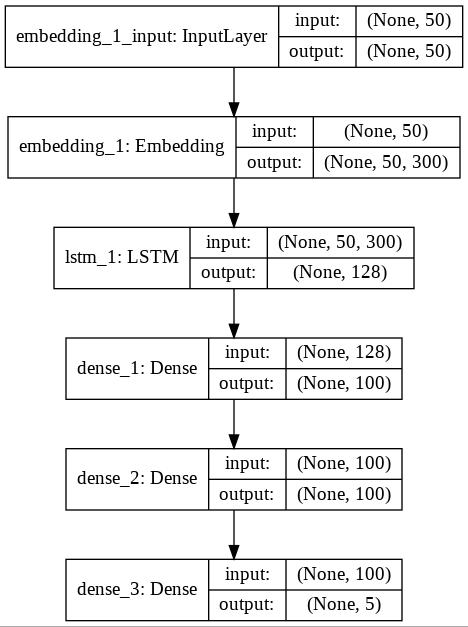

In [60]:
from keras.utils.vis_utils import plot_model
plot_model(model_lstm, to_file='model_plot.jpeg', show_shapes=True, show_layer_names=True)

In [61]:
def create_nn():
  model = Sequential()
  model.add(Embedding(vocab_size,300,weights=[embedding_matrix],input_length=max_len,trainable=False))
  model.add(LSTM(128,dropout=0.5))
  model.add(Dense(100,activation='relu'))
  model.add(Dense(100,activation='relu'))
  model.add(Dense(5,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

  return model

In [62]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(df['sentiment'])
labels = to_categorical(labels)

In [63]:
# Evaluate neural network using three-fold cross-validation
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

#Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_nn, 
                                 epochs=10,  
                                 verbose=0)

cross_val_score(neural_network,data, labels, cv=3)

array([0.55060208, 0.55703652, 0.55166394])